In [1]:
# Basic libraries
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import shutil
import multiprocessing
from multiprocessing.pool import ThreadPool
import os
print('CWD is ',os.getcwd())

# Visualization
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image

from PIL import Image
import cv2

# DL
import keras
from keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras import optimizers,Model,Sequential
from tensorflow.keras.applications import ResNet50
from keras.optimizers import Adam

In [2]:
# Visualization
def load_data():
    train = pd.read_csv(r"F:\Train\train.csv")
    
    train_dir = os.path.join(r"F:\Train\train_images")
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    
    train['file_name'] = train['id_code'].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train

In [4]:
df_train = load_data()
print(df_train.shape)
print(df_train.head(6))

(3662, 4)
        id_code diagnosis                               file_path  \
0  000c1434d8d7         2  F:\Train\train_images\000c1434d8d7.png   
1  001639a390f0         4  F:\Train\train_images\001639a390f0.png   
2  0024cdab0c1e         1  F:\Train\train_images\0024cdab0c1e.png   
3  002c21358ce6         0  F:\Train\train_images\002c21358ce6.png   
4  005b95c28852         0  F:\Train\train_images\005b95c28852.png   
5  0083ee8054ee         4  F:\Train\train_images\0083ee8054ee.png   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
5  0083ee8054ee.png  


In [5]:
# Class Distribution
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']
    
    sns.set(rc={'figure.figsize':(10,5)}, style='whitegrid')
    sns.barplot(x='diagnosis', y='count', data=df_group, palette="Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

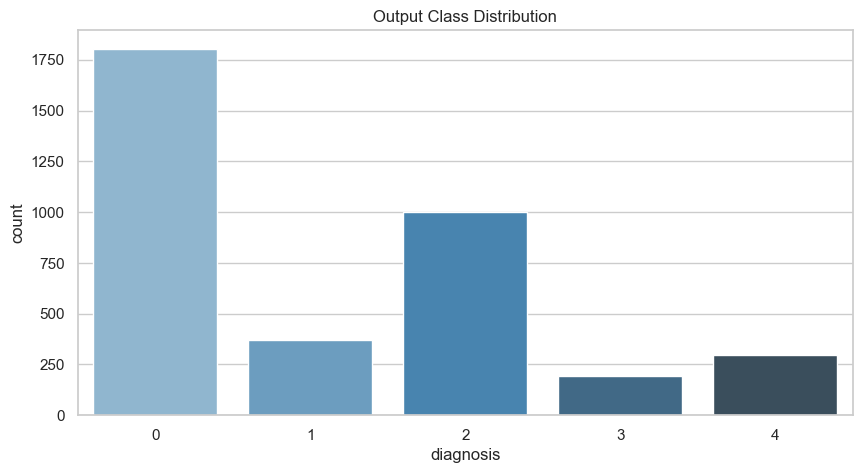

In [6]:
plot_classes(df_train)

In [7]:
# Visualizing Images

# Defining a global variable to be used as Image size....!

IMG_SIZE = 200

In [8]:
# Convert Color image to gray scale 

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

# Visual image photo of 'n X 5' points (5 of each class)

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys=False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize=(15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap=color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))
            
        plt.show()    

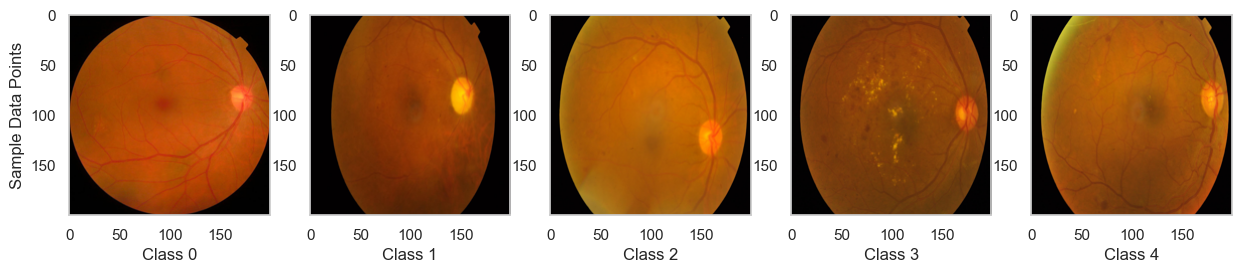

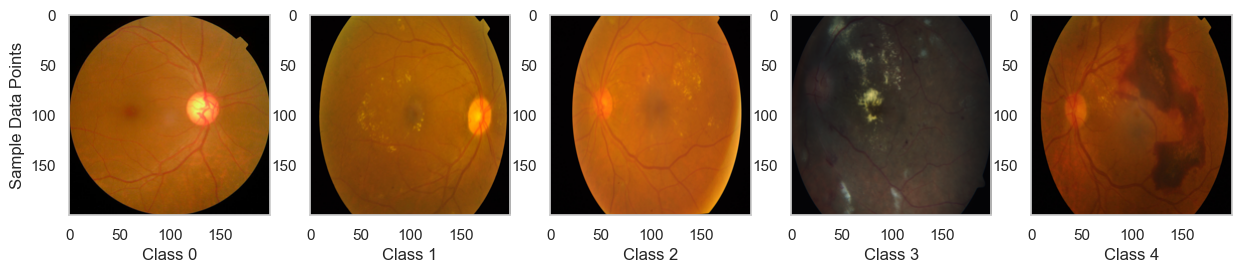

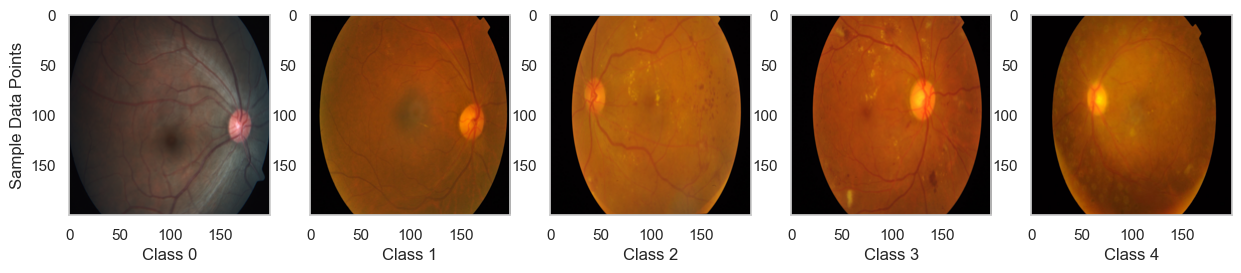

In [10]:
visualize_imgs(df_train,3,color_scale=None)

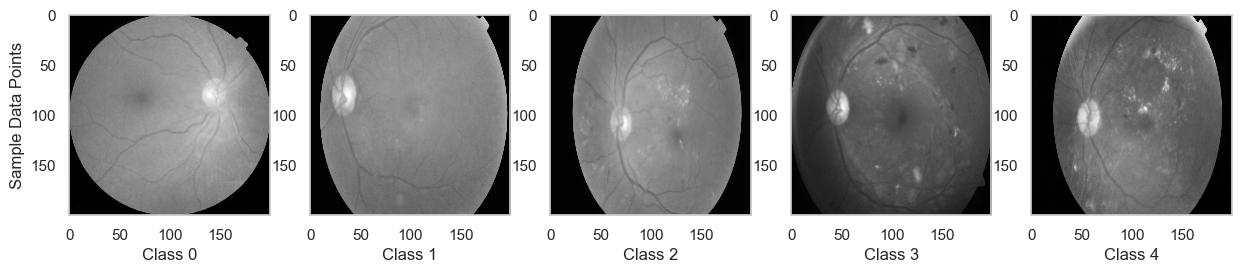

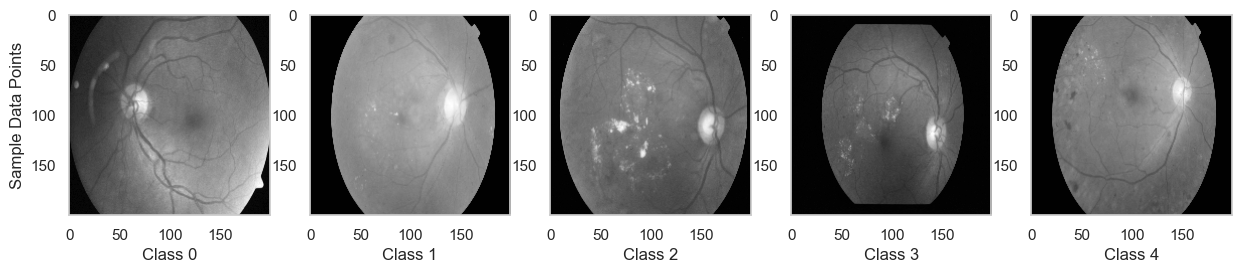

In [11]:
visualize_imgs(df_train,2,color_scale='gray')

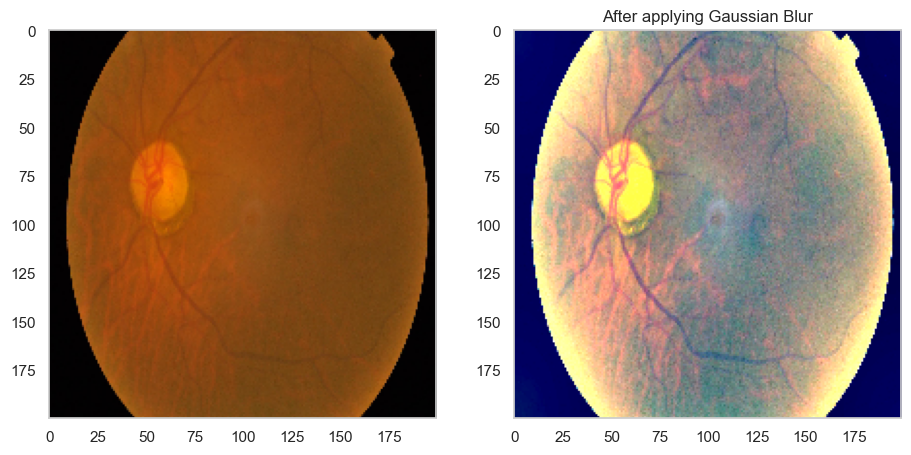

In [12]:
# Image Processing

# Gaussian Blur

rn = np.random.randint(low=0,high=len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img,(0,0),30),-4,128)

f, axarr = plt.subplots(1,2,figsize=(11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

In [13]:
# Circular cropping with Gaussian Blur

def crop_image_from_gray(img,tol=7):
    if img.ndim == 2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        # If image is too dark return to original image
        if (check_shape == 0): 
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            print(img1.shape, img2.shape, img3.shape)
            
            img = np.stack([img1,img2,img3],axis=-1)
            print(img.shape)
        return img

In [14]:
# Create Circular crop around image center
def circle_crop(img, sigmaX):
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX),-4,128)
    return img

(2136, 2720) (2136, 2720) (2136, 2720)
(2136, 2720, 3)
(2136, 2137) (2136, 2137) (2136, 2137)
(2136, 2137, 3)


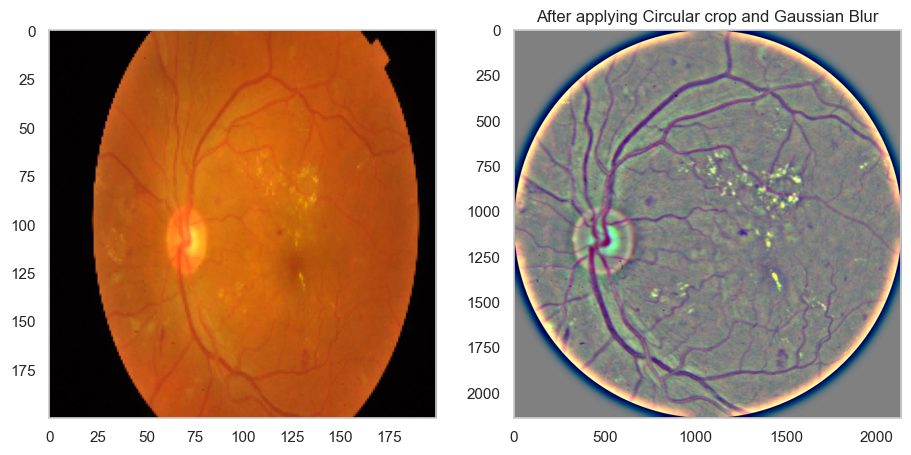

In [15]:
# Perform image pre-processing

rn = np.random.randint(low=0,high=len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX=30)

f, axarr = plt.subplots(1,2,figsize=(11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title("After applying Circular crop and Gaussian Blur")
plt.show()

In [16]:
# Image processing transformation of 'n X 5' points visual images

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys=False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize=(15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1),pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))
            
        plt.show()

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1049, 1049) (1049, 1049) (1049, 1049)
(1049, 1049, 3)
(2136, 2712) (2136, 2712) (2136, 2712)
(2136, 2712, 3)
(2136, 2137) (2136, 2137) (2136, 2137)
(2136, 2137, 3)
(1226, 1511) (1226, 1511) (1226, 1511)
(1226, 1511, 3)
(1226, 1227) (1226, 1227) (1226, 1227)
(1226, 1227, 3)
(1736, 2261) (1736, 2261) (1736, 2261)
(1736, 2261, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)


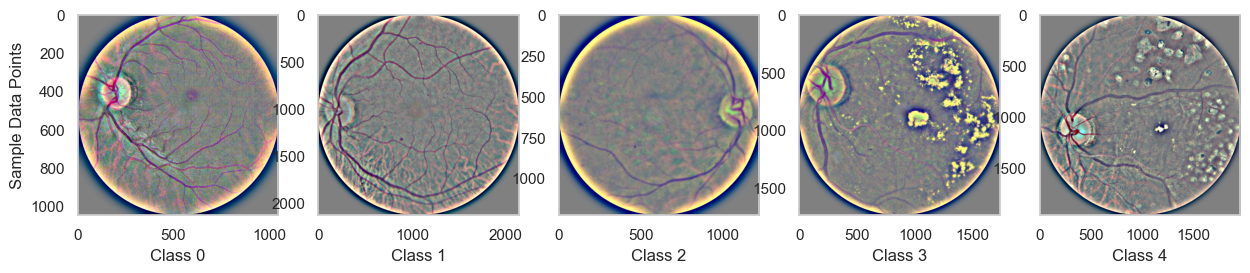

(1380, 1381) (1380, 1381) (1380, 1381)
(1380, 1381, 3)
(1379, 1378) (1379, 1378) (1379, 1378)
(1379, 1378, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)
(2535, 3028) (2535, 3028) (2535, 3028)
(2535, 3028, 3)
(2531, 2535) (2531, 2535) (2531, 2535)
(2531, 2535, 3)


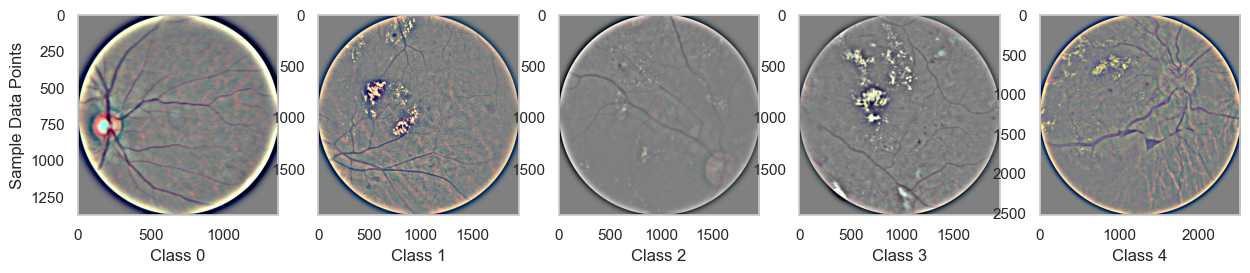

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1050, 1049) (1050, 1049) (1050, 1049)
(1050, 1049, 3)
(1958, 2588) (1958, 2588) (1958, 2588)
(1958, 2588, 3)
(1958, 1959) (1958, 1959) (1958, 1959)
(1958, 1959, 3)
(1736, 2260) (1736, 2260) (1736, 2260)
(1736, 2260, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(968, 1260) (968, 1260) (968, 1260)
(968, 1260, 3)
(962, 969) (962, 969) (962, 969)
(962, 969, 3)
(1226, 1510) (1226, 1510) (1226, 1510)
(1226, 1510, 3)
(1226, 1227) (1226, 1227) (1226, 1227)
(1226, 1227, 3)


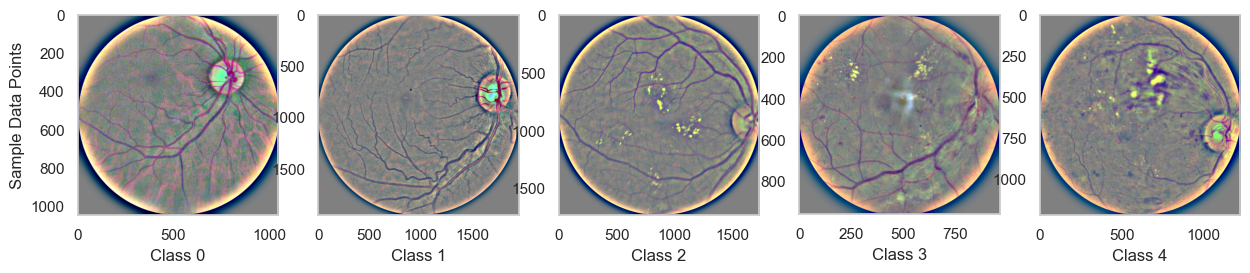

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 1050, 3)
(1050, 1049) (1050, 1049) (1050, 1049)
(1050, 1049, 3)
(1736, 2264) (1736, 2264) (1736, 2264)
(1736, 2264, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(1736, 2259) (1736, 2259) (1736, 2259)
(1736, 2259, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(2742, 3621) (2742, 3621) (2742, 3621)
(2742, 3621, 3)
(2738, 2743) (2738, 2743) (2738, 2743)
(2738, 2743, 3)
(2536, 3024) (2536, 3024) (2536, 3024)
(2536, 3024, 3)
(2514, 2537) (2514, 2537) (2514, 2537)
(2514, 2537, 3)


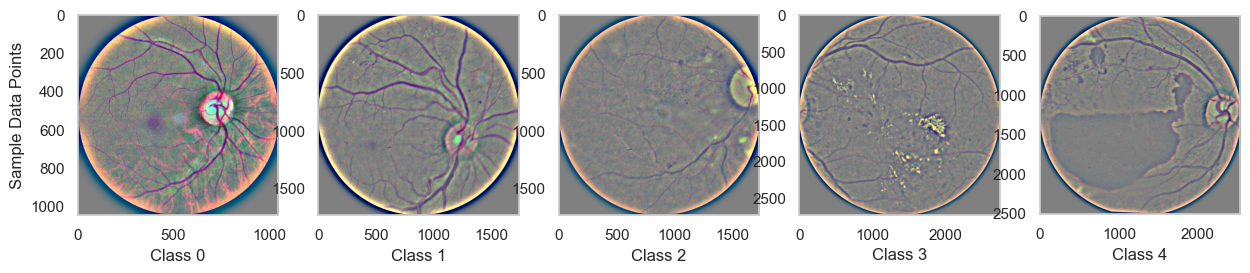

(614, 759) (614, 759) (614, 759)
(614, 759, 3)
(614, 615) (614, 615) (614, 615)
(614, 615, 3)
(1736, 2260) (1736, 2260) (1736, 2260)
(1736, 2260, 3)
(1736, 1737) (1736, 1737) (1736, 1737)
(1736, 1737, 3)
(2520, 3035) (2520, 3035) (2520, 3035)
(2520, 3035, 3)
(2508, 2521) (2508, 2521) (2508, 2521)
(2508, 2521, 3)
(1765, 2051) (1765, 2051) (1765, 2051)
(1765, 2051, 3)
(1751, 1765) (1751, 1765) (1751, 1765)
(1751, 1765, 3)
(2536, 3026) (2536, 3026) (2536, 3026)
(2536, 3026, 3)
(2515, 2537) (2515, 2537) (2515, 2537)
(2515, 2537, 3)


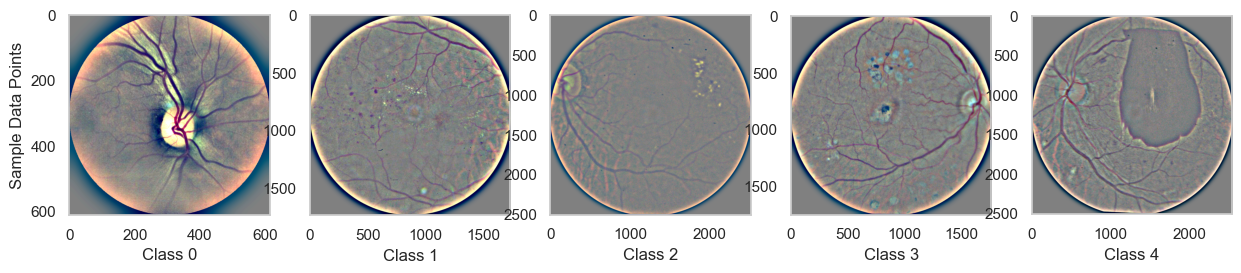

In [17]:
visualize_img_process(df_train,5,sigmaX=30)

In [18]:
# TSNE Visualization - On Gray Scale Images

# The image is flattened to 2D Gray image to 1D and then applies TSNE

# Train image Data
npix = 224 # Resize only for now
X_train = np.zeros((df_train.shape[0], npix,npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_train[i,:,:] = cv2.resize(img, (npix,npix))
    
print("X_train shape: " + str(np.shape(X_train)))

  0%|          | 0/3662 [00:00<?, ?it/s]

X_train shape: (3662, 224, 224)


In [19]:
# Normalize
X = X_train / 255

# Reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

  0%|          | 0/8 [00:00<?, ?it/s]

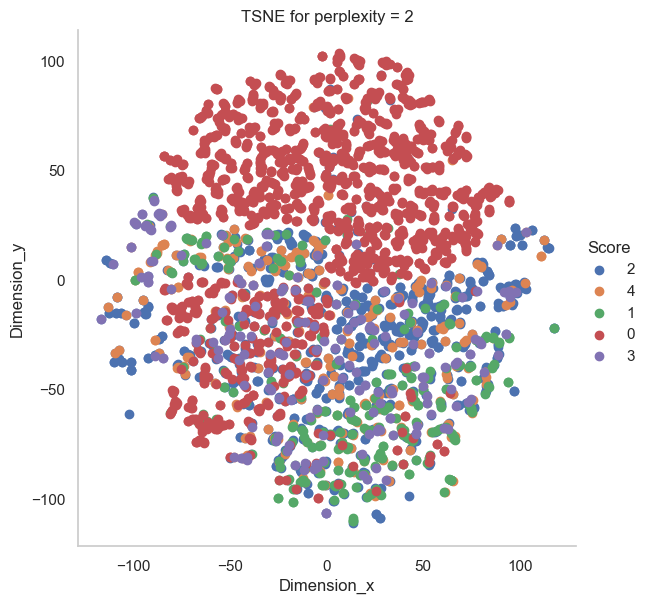

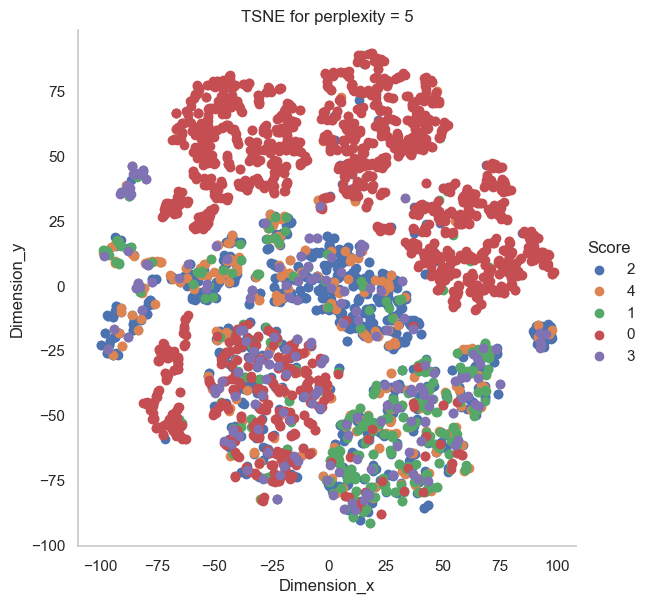

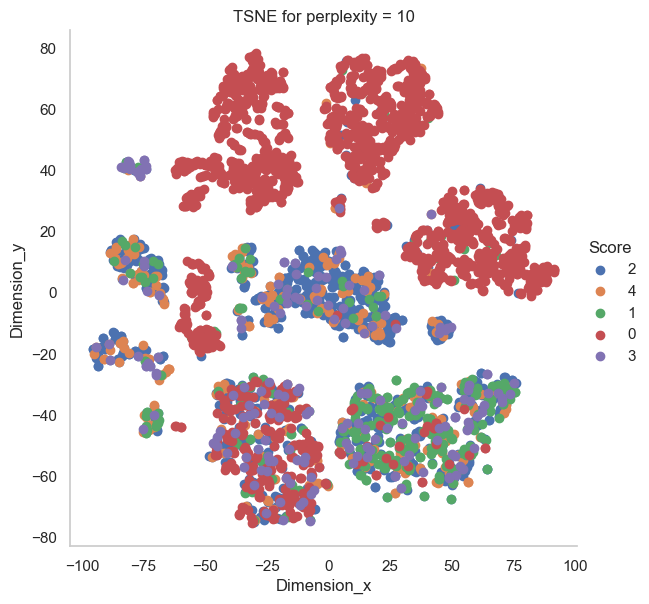

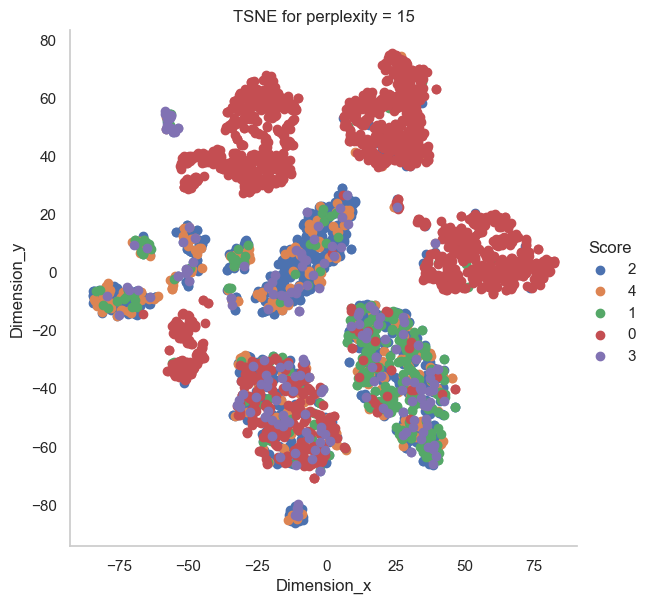

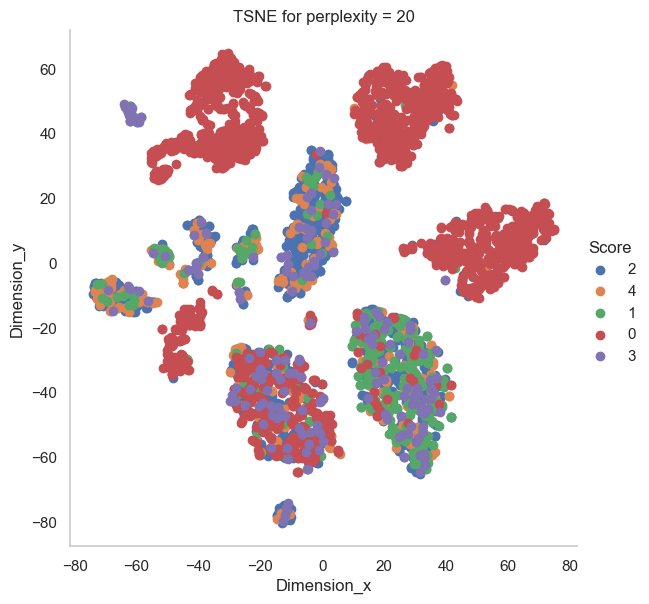

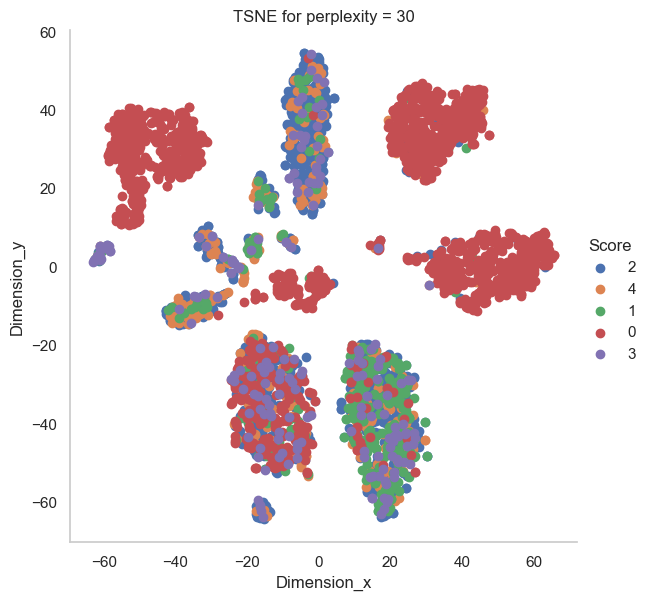

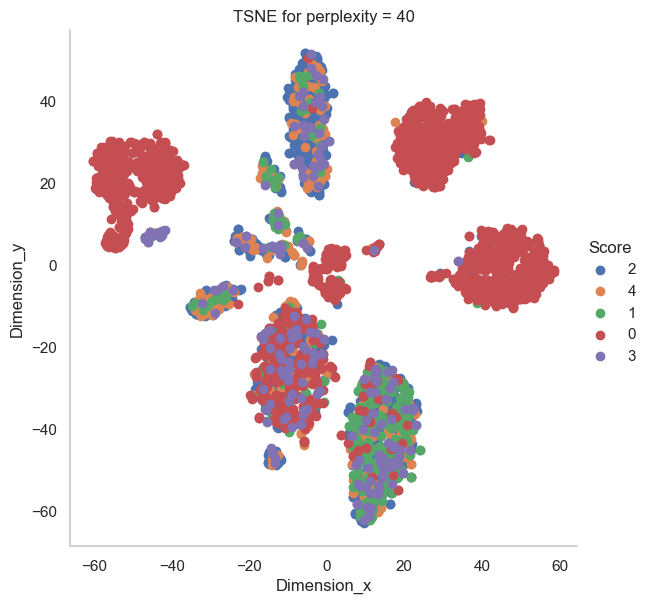

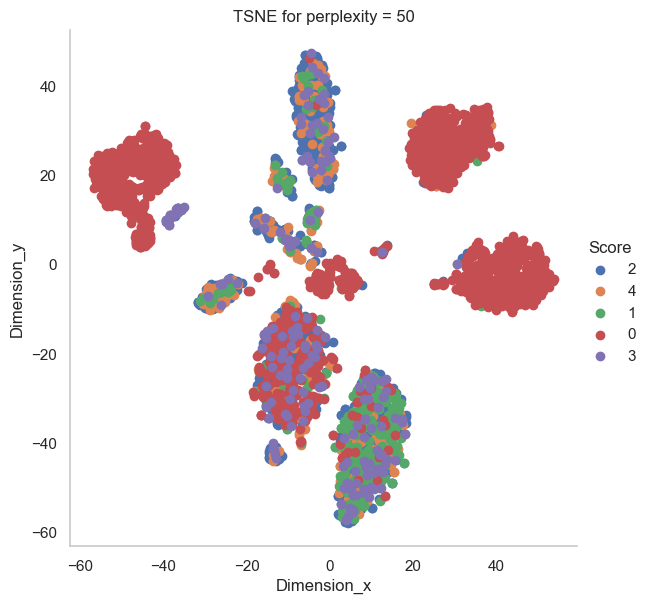

In [20]:
per_vals = [2,5,10,15,20,30,40,50]
for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity=per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', height=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

In [21]:
# Data Augmentation
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

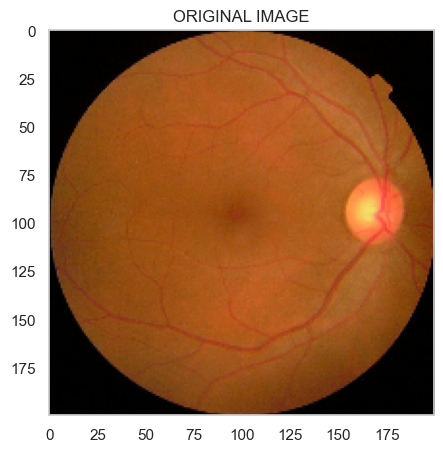

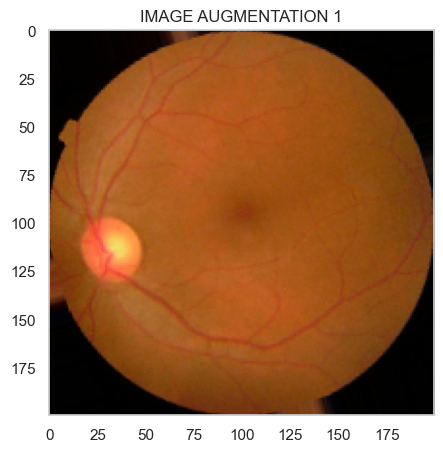

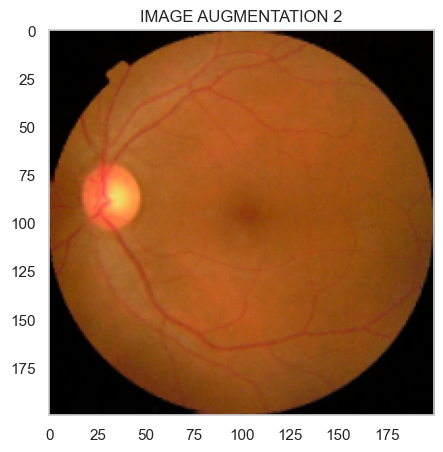

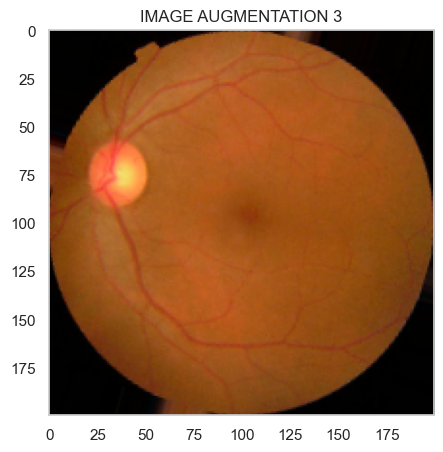

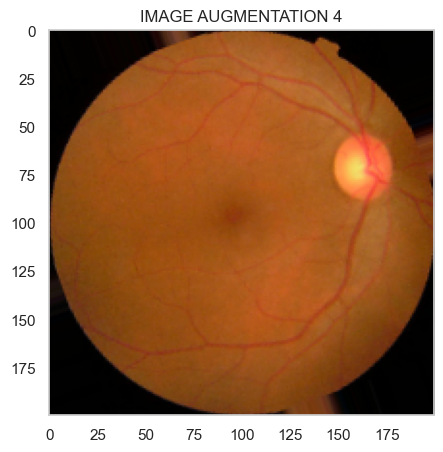

In [22]:
generate_augmentations(4)